# Libraries

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

# Data

In [48]:
# load your dataset
df_train = pd.read_parquet('./data/cic_iomt_2024_wifi_mqtt_train.parquet')  # load your training data
df_test = pd.read_parquet('./data/cic_iomt_2024_wifi_mqtt_test.parquet')   # load your test data

# randomly select % of the training and test data (for exploration)
df_train_sampled = df_train.sample(frac=0.001, random_state=1984)        # % of train data
df_test_sampled = df_test.sample(frac=1, random_state=1984)              # % of test data

# define training and testing features and labels
X_train = df_train_sampled.drop(columns=['label', 'class_label', 'category_label', 'attack_label'])
y_train = df_train_sampled['attack_label']
X_test = df_test_sampled.drop(columns=['label', 'class_label', 'category_label', 'attack_label'])
y_test = df_test_sampled['attack_label']

# PSO

##### This code implements Particle Swarm Optimization (PSO) for feature selection in a classification task using a Random Forest classifier. The idea is to optimize the selection of features from the dataset by treating the selection problem as a swarm optimization problem, where each particle in the swarm represents a potential solution (a subset of features).

In [39]:
# define the fitness function for evaluating feature subsets
def evaluate_feature_selection(particle):
    # function selects the features based on the particle's position vector - features with values > 0.5 are selected
    selected_features = np.where(particle > 0.5)[0]  # select features based on particle position
    if len(selected_features) == 0:                  # avoid empty feature set
        return 0
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]

    rf = RandomForestClassifier(random_state=1984)   # create rf model
    rf.fit(X_train_selected, y_train)                # fit the model
    y_pred = rf.predict(X_test_selected)             # predict attack_label
    
    accuracy = accuracy_score(y_test, y_pred)        # calculate accuracy of prediction - fitness function
    return accuracy                                  # return accuracy as the fitness score

In [52]:
# Particle class for feature selection
# Each particle in PSO represents a candidate solution for feature selection
class FeatureParticle:
    def __init__(self, n_features):
        self.position = np.random.rand(n_features)                     # random values between 0 and 1 for each feature in dataset
        self.velocity = np.zeros(n_features)                           # velocity of the particle
        self.best_position = np.copy(self.position)                    # feature subset (the best) that this particle has encountered
        self.best_fitness = evaluate_feature_selection(self.position)  # classification accuracy of the best feature

In [41]:
# PSO parameters
num_particles = 10                          # number of particles in the swarm - number of candidate solutions
num_iterations = 20                         # number of iteration the algorithm will run
n_features = X_train.shape[1]               # number of features in dataset (45), each particle will have a postion of lenghth n_features

# create list of particles
particles = []                              # initialize an empty list to hold the particles
for _ in range(num_particles):              # based on defined above number of particles
    particle = FeatureParticle(n_features)  # create a new particle
    particles.append(particle)              # add the particle to the list

In [42]:
# Initialize global best
global_best_position = particles[0].best_position
global_best_fitness = particles[0].best_fitness

In [43]:
# PSO main loop for feature selection
for iteration in range(num_iterations):
    for particle in particles:
        # evaluate fitness (accuracy) of the particle
        fitness = evaluate_feature_selection(particle.position)
        
        # update personal best
        if fitness > particle.best_fitness:
            particle.best_fitness = fitness
            particle.best_position = np.copy(particle.position)
        
        # update global best
        if fitness > global_best_fitness:
            global_best_fitness = fitness
            global_best_position = np.copy(particle.position)

        # update velocity and position
        inertia_weight = 0.5
        cognitive_component = 1.5
        social_component = 1.5

        for i in range(len(particle.position)):
            r1, r2 = np.random.rand(), np.random.rand()
            particle.velocity[i] = (inertia_weight * particle.velocity[i] +
                                    cognitive_component * r1 * (particle.best_position[i] - particle.position[i]) +
                                    social_component * r2 * (global_best_position[i] - particle.position[i]))
            particle.position[i] += particle.velocity[i]
            
            # ensure position is a valid feature selection (0 or 1)
            particle.position[i] = 1 if particle.position[i] > 0.5 else 0

# Random Forest Classifier

In [49]:
# use the best features identified by PSO
selected_features = np.where(global_best_position > 0.5)[0]
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

# train the Random Forest with selected features
rf = RandomForestClassifier(random_state=1984)
rf.fit(X_train_selected, y_train)
y_pred = rf.predict(X_test_selected)

                    precision    recall  f1-score   support

      ARP_spoofing       0.33      0.05      0.09      1744
            Benign       0.89      0.90      0.90     37607
         DDoS_ICMP       1.00      1.00      1.00    349699
          DDoS_SYN       1.00      1.00      1.00    172397
          DDoS_TCP       1.00      1.00      1.00    182598
          DDoS_UDP       1.00      1.00      1.00    362070
DDoS_connect_flood       1.00      1.00      1.00     41916
DDoS_publish_flood       0.94      0.20      0.32      8416
          DoS_ICMP       1.00      1.00      1.00     98432
           DoS_SYN       1.00      1.00      1.00     98595
           DoS_TCP       0.99      1.00      1.00     82096
           DoS_UDP       1.00      1.00      1.00    137553
 DoS_connect_flood       0.99      0.99      0.99      3131
 DoS_publish_flood       0.55      0.98      0.71      8505
    Malformed_date       0.98      0.28      0.43      1747
           OS_scan       0.67      0.31

In [ ]:
# print the classification report
print(classification_report(y_test, y_pred))

# print the number of selected features
print(f"Number of selected features: {len(selected_features)}")

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# print accuracy with 5 decimal places
print(f"Accuracy: {accuracy:.5f}")

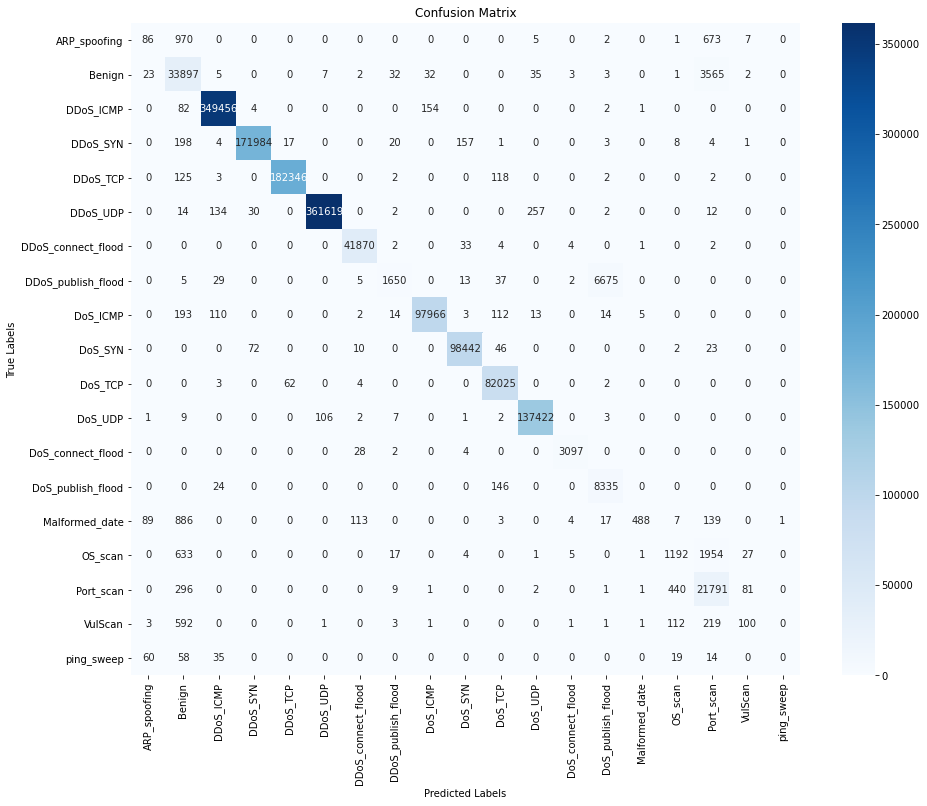

In [51]:
# generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# visualize the confusion matrix using seaborn
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# This notebook demonstrates how Particle Swarm Optimization (PSO) can be applied to reduce the dimensionality of a dataset before training a machine learning model. By selecting the most relevant features, PSO helps to optimize the model's performance while potentially reducing computational costs and increasing the speed of an Intrusion Detection System (IDS). Feature reduction through PSO allows the model to focus on the most informative data, which can lead to faster training times and more efficient resource usage.